In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import climpred as cp
import glob
import xarray as xr
from dask.diagnostics import ProgressBar

In [3]:
rootdir = '/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1'
prod = 'gfdl.ncrc4-intel18-prod-openmp'
configid_control = 'ESM4_piControl_D'

In [4]:
import gfdl_utils as gu
import re

In [5]:
def get_ensembleid(startyearstr,startmonthstr):
    return startyearstr+startmonthstr+'01'

def get_memberid(startyear,startmonth,member):
    memberdict=dict(startyear=startyear,startmonth=startmonth,member=member)
    zfilldict=dict(startyear=4,startmonth=2,member=2)
    memberstrdict=memberdict.copy()
    for key,value in memberdict.items():
        if value is None:
            memberstrdict[key]='*'
        elif isinstance(value,int):
            memberstrdict[key] = str(value).zfill(zfilldict[key])
    return '-'.join([get_ensembleid(memberstrdict['startyear'],memberstrdict['startmonth']),memberstrdict['member']])

def get_configid(startyear=None,startmonth=None,member=None):
    if all(n is None for n in [startyear,startmonth,member]):
        return configid_control
    else:
        return '-'.join([configid_control,'ensemble',get_memberid(startyear,startmonth,member)])
    
def get_pp(startyear=None,startmonth=None,member=None):
    return '/'.join([rootdir,get_configid(startyear,startmonth,member),prod,'pp'])

def get_refpp(startmonth):
    # Appropriate reference pp varies depending on ensemble's startmonth
    # Note that these could be changed or user-specified
    if startmonth is None:
        return get_pp() # Control
    else:
        return get_pp(123,startmonth,1)

In [6]:
def get_ppname(variable, frequency, pp=None, constraint=None):
    if (pp is None) or (bool(re.search("\*",pp))):
        # Use main reference pp
        # For the purposes of finding the ppname, startmonth is irrelevant
        # so it isn't carried here
        pp = get_pp()
    ppnames = gu.core.find_variable(pp,variable)
    if len(ppnames)==1:
        ppname = ppnames[0]
        if confirm_frequency(pp,ppname,frequency):
            return ppname
        else:
            raise Exception(("Variable {"+variable
                             +"} only found in {"+ppname
                             +"}, which has frequency {"+gu.core.get_timefrequency(pp,ppname)
                             +"} but frequency {"+frequency
                             +"} was requested."))
    for ppname in ppnames:
        
        if constraint is None:
            condition = confirm_frequency(pp,ppname,frequency)
        else:
            condition = confirm_frequency(pp,ppname,frequency) & (bool(re.search(constraint,ppname)))
                
        if condition:
            return ppname
        else:
            continue
            
    exceptionstr = ("No suitable ppname found for {"+variable
                     +"} at frequency {"+frequency+"}")
    if constraint is not None:
        exceptionstr+=" with constraint {'"+constraint+"'}"
    raise Exception(exceptionstr)

def get_local(pp,ppname,startmonth):
    if bool(re.search("\*",pp)):
        # Use reference pp
        pp = get_refpp(startmonth)
    local = gu.core.get_local(pp,ppname,out='ts')
    if (startmonth is None) or (startmonth=='*'):
        local = '/'.join([local.split('/')[0],'*yr'])
    return local

def confirm_frequency(pp,ppname,frequency):
    return gu.core.get_timefrequency(pp,ppname)==frequency

In [7]:
def get_pathDict(variable,frequency,constraint=None,startyear=None,startmonth=None,member=None,time='*',out='ts'):
    pp = get_pp(startyear,startmonth,member)
    ppname = get_ppname(variable,frequency,constraint)
    local = get_local(pp,ppname,startmonth)
    return {'pp':pp,
            'ppname':ppname,
            'out':out,
            'local':local,
            'time':time,
            'add':variable}

In [8]:
import cftime
import numpy as np
import pandas as pd

In [9]:
def preprocess_climpred(ds,leadunits='months'):
    nt = len(ds['time'])
    leadunitsperyear = {'years':1,
                        'months':12,
                        'days':365}
    # Recover ensemble details from "title" attribute
    title = ds.attrs['title']
    member = int(title.split('-')[-1])
    ensembleid = title.split('-')[-2]
    startyear = int(ensembleid[0:4])
    startmonth = int(ensembleid[4:6])
    # Check if getting first saved pp file
    yearssincestart = ds['time'][0].dt.year.values-startyear
    if yearssincestart==0:
        leadstart = 1
    else:
        leadstart = yearssincestart*leadunitsperyear[leadunits]+1
        
    # Expand init dimension
    init = cftime.DatetimeNoLeap(startyear,startmonth,1)
    ds = ds.expand_dims({'init':[init]})
    # Expand member dimension
    ds = ds.expand_dims({'member':[member]})
    # Assign "lead" coordinate
    ds = ds.rename({'time':'lead'}).assign_coords({'lead':np.arange(leadstart,leadstart+nt)})
    ds['lead'].attrs['units']=leadunits
        
    ds = ds.chunk({'lead':-1})
    return ds

In [10]:
def add_controlasmember(ds,control):
    cs = ds.isel(member=0).copy().expand_dims({'member':[0]})
    for init in ds['init']:
        # Get appropriate slice
        if init.dt.month==1:
            nlead = len(ds['lead'])
        else:
            nlead = 36
        timeslice = slice(
            ds['time_bnds'].sel(init=init).isel(nv=0,member=0,lead=0).values,
            ds['time_bnds'].sel(init=init).isel(nv=1,member=0,lead=nlead-1).values)
        daslice = control.sel(time=timeslice)
        daslice = daslice.rename({'time':'lead'}).assign_coords({'lead':np.arange(1,nlead+1)})
        # Add slice to "controlmember" dataset
        da = cs.sel(init=init)
        da.loc[{'lead':np.arange(1,nlead+1)}]=daslice
        cs.loc[{'init':init}] = da
    return xr.concat([cs,ds],dim='member')

def open_control(variable,frequency,constraint=None):
    pathDict = get_pathDict(variable,frequency,constraint=constraint)
    path = gu.core.get_pathspp(**pathDict)
    ondisk = gu.core.query_ondisk(path)
    if list(ondisk.values()).count(False)>0:
        raise Exception("Not all files (CONTROL) available on disk. Use issue_dmget_ensemble(variable,frequency,...) to migrate from tape.")
    return xr.open_mfdataset(path)

def open_static(variable,frequency,constraint=None):
    pathDict = get_pathDict(variable,frequency,constraint=constraint)
    return gu.core.open_static(pathDict['pp'],pathDict['ppname'])

def open_ensemble(variable,frequency,constraint=None,startyear="*",startmonth=None,controlasmember=True):
    pathDict = get_pathDict(variable,frequency,constraint,startyear,startmonth)
    path = gu.core.get_pathspp(**pathDict)
    # Check to see if files are on disk or tape
    ondisk = gu.core.query_ondisk(path)
    if list(ondisk.values()).count(False)>0:
        raise Exception("Not all files (ENSEMBLES) available on disk. Use issue_dmget_ensemble(variable,frequency,...) to migrate from tape.")
    ds = xr.open_mfdataset(path,preprocess=preprocess_climpred)
    # Add control as member
    if controlasmember:
        control = open_control(variable,frequency,constraint)
        ds = add_controlasmember(ds,control)
    return ds

def issue_dmget_esm4ppe(variable,frequency,constraint=None,startyear=None,startmonth=None):
    pathDict = get_pathDict(variable,frequency,constraint,startyear,startmonth)
    path = gu.core.get_pathspp(**pathDict)
    ondisk = gu.core.query_ondisk(path)
    ontape = {key: value for key, value in ondisk.items() if value==False}
    out = gu.core.issue_dmget(list(ontape.keys()))
    return out

In [11]:
import os
import time

In [35]:
class esm4ppeObj:
    def __init__(self,variable,frequency,constraint=None,triggeropen=False,add_control=False):
        zarrpath = '/work/gam/projects/esm4_ppe/data/raw/climpred_zarr/'+get_zarrdir(variable,frequency)
        try:
            ds = xr.open_zarr(zarrpath)[variable]
            print("Opening zarr store.")
        except:
            if triggeropen:
                print("Opening ensemble...",end=" ")
                start = time.time()
                ds = open_ensemble(variable,frequency,constraint,controlasmember=True)
                end = time.time()
                print("...Ensemble opened. Elapsed time: "+str(round(end-start))+" seconds.")
                ds = ds.drop(['time_bnds','nv']).chunk({'member':-1,'init':-1,'lead':1,'xh':"auto"})
                print("Saving to zarr store...",end=" ")
                with ProgressBar():
                    ds.to_zarr(zarrpath,mode='a')
                print("zarr store saved.")
            else:
                raise Exception("Zarr store not available for "+
                                variable+" at zarrpath "+
                                get_zarrpath(variable,frequency)+"."+
                                "Set triggeropen=True to open and save the ensemble."+
                                " This can take some time to process.")
        
        if type(ds)==xr.DataArray:
            ds = ds.to_dataset()
        self._ds = ds
        
        self.args = {'variable':variable,'frequency':frequency,'constraint':constraint}
        self.zarrpath = zarrpath
        
        if add_control:
            print("Opening control...",end=" ")
            self._control = open_control(variable,frequency,constraint)
            print("control opened.")
        
        print("Opening static...",end=" ")
        self._static = open_static(variable,frequency,constraint)
        print("static opened.")
        
        
    def verify(self,metric,saveskill=False,**pm_args):
        verifypath = get_verifypath(metric,**pm_args)
        path = verifypath+'/'+get_ncfilename(self.args)         
        try:
            vs = xr.open_dataset(path)
            print("Opening skill metric.")
        except:
            vs = self._verify(metric,**pm_args)
            if saveskill:
                isExist = os.path.exists(verifypath)
                if not isExist:
                    os.mkdir(verifypath)
                print("Saving skill metric...",end=" ")
                with ProgressBar():
                    vs.to_netcdf(path)
                print("...skill metric saved")
        self._vs = vs
        self.verifypath = verifypath
        return vs
    
    def _verify(self,metric,**pm_args):
        if metric=='ppp':
            if 'groupby' in pm_args.keys():
                groupby=pm_args['groupby']
            else:
                groupby=None
            return calc_ppp(self._ds,self._control,groupby,self.args['frequency'],len(self._ds['lead']))
        else:
            pm = cp.PerfectModelEnsemble(self._ds)
            return pm.verify(metric=metric,**pm_args)
        
def get_verifypath(metric,**pm_args):
    rootpath = '/work/gam/projects/esm4_ppe/data/processed/verify/'
    verifypathstrings = ['verify','metric-'+metric]
    for key,value in pm_args.items():
        if value==None:
            continue
        elif type(value)==list:
            string = '-'.join([key,'_'.join(value)])
        else:
            string= '-'.join([key,value])
        verifypathstrings.append(string)
    return rootpath+'.'.join(verifypathstrings)

def get_ncfilename(args):
    tmp = list(args.values())
    tmp_nonone = [i for i in tmp if i is not None]
    return '.'.join(tmp_nonone)+'.nc'

def get_zarrdir(variable,frequency):
    ppname = get_ppname(variable,frequency).split('_')
    modelcomponent = ppname[0]
    return '.'.join([modelcomponent,frequency])

In [13]:
def calc_ensemblevariance(ds,groupby=None):
    evar = (ds.std(dim='member'))**2
    if groupby is not None:
        return evar.groupby('init.'+groupby).mean()
    else:
        return evar.mean('init')

def calc_controlvariance(control,frequency,nlead):
    if frequency=='monthly':
        tmp = (control.groupby('time.month').std()**2)
        # Broadcast to nlead/12 repeating years
        montharray = np.tile(tmp['month'].to_numpy(),int(nlead/12))
        tmp = tmp.sel(month=montharray).rename({'month':'lead'})
        cvar = tmp.assign_coords({'lead':np.arange(1,nlead+1)})
    elif frequency=='annual':
        tmp = (control.std('time')**2).expand_dims({'lead':1})
        tmp = tmp.isel(time=[0]*n)
        cvar = tmp.assign_coords({'lead':np.arange(1,nlead+1)})
    return cvar
        
def calc_ppp(ds,control,groupby,frequency,nlead):
    # Ensemble variance
    evarmean = calc_ensemblevariance(ds,groupby)

    # Control variance
    cvar = calc_controlvariance(control,frequency,nlead)
    # If necessary, shift control variance to align with init month
    if groupby=='month':
        cvar_month = cvar.expand_dims({'month':evarmean['month']})
        for m in cvar_month['month'].values:
            cvar_month.loc[{'month':m}]=cvar.shift(lead=-1*(m-1))
    # PPP
    ppp = 1-(evarmean/cvar)
    return ppp

In [26]:
variable = 'epc100'
frequency = 'monthly'

In [27]:
%%time
eo = esm4ppeObj(variable,frequency,add_control=True,triggeropen=True)

Opening ensemble... ...Ensemble opened. Elapsed time: 326 seconds.
[########################################] | 100% Completed | 234.86 s
zarr store saved.
Opening control... control opened.
Opening static... static opened.
CPU times: user 10min 23s, sys: 13min 50s, total: 24min 14s
Wall time: 9min 54s


In [30]:
vs = eo.verify('ppp',groupby='month',saveskill=True)

Opening skill metric.


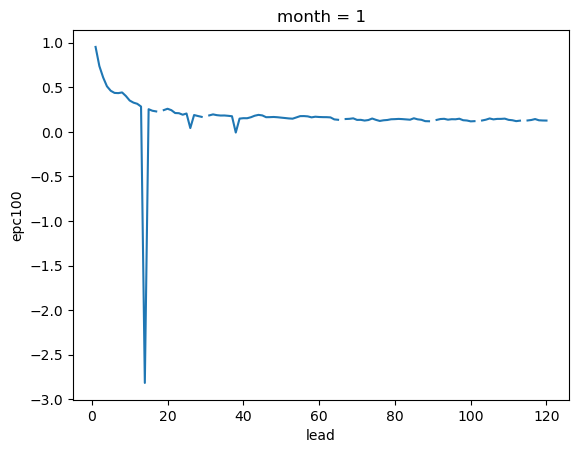

In [34]:
vs[variable].weighted(eo._static['areacello'].fillna(0)).mean(['xh','yh']).isel(month=0).plot()